In [1]:
import matplotlib.pyplot as plt
import pingouin as pg
import seaborn as sns
from drn_interactions.config import Config
from drn_interactions.io import load_derived_generic
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu
from drn_interactions.stats import mannwhitneyu_plusplus

from drn_interactions.transforms.spikes import SpikesHandlerMulti
from drn_interactions.config import Config, ExperimentInfo
from drn_interactions.io import load_events, load_derived_generic
from drn_interactions.responders.foot_shock import SpikeRateResponders
import pandas as pd
import numpy as np
from IPython.display import display
from scipy.stats import zscore, zmap
import warnings
from drn_interactions.transforms.shock_transforms import ShockUtils
from drn_interactions.transforms.spikes import SpikesHandler
from drn_interactions.responders.foot_shock import AlignedResponders
from drn_interactions.plots import PAL_GREY_BLACK
import seaborn as sns

sns.set_theme(style="ticks", context="paper")

c:\Users\roryl\.conda\envs\drn_final\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
c:\Users\roryl\.conda\envs\drn_final\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
fig_dir = Config.fig_dir

pop = (
    load_derived_generic("decoding/fs_fast - pop.csv")
    .rename(columns=dict(pop_true="Population", shuffle="Shuffle"))
)
unit = load_derived_generic("decoding/fs_fast - unit.csv")
limit = (
    load_derived_generic("decoding/fs_fast - limit.csv")
    .loc[lambda x: x.n_neurons <= 15]
)
dropout = load_derived_generic("decoding/fs_fast - dropout.csv")

pop = (
    unit
    .groupby("session_name")["F1 Score"].max()
    .to_frame("Best Neuron")
    .reset_index()
    .merge(pop, on="session_name")
    .melt(id_vars="session_name", var_name="metric", value_name="value")
    .assign(metric = lambda x: pd.Categorical(x.metric, categories=["Population", "Best Neuron", "Shuffle"]))
)

In [14]:
from scipy.stats import wilcoxon

df_piv = pop.pivot(index="session_name", columns="metric", values="value")
W, p = wilcoxon(df_piv["Population"], df_piv["Best Neuron"])
print(f"Population vs Best Neuron: W = {W}, p = {p}")
print(df_piv["Population"].median(), df_piv["Best Neuron"].median())

Population vs Best Neuron: W = 0.0, p = 0.0078125
0.8330987826117394 0.7673270830096834


In [15]:
from scipy.stats import ttest_1samp

ttest_1samp(df_piv["Shuffle"], popmean=0.5)

Ttest_1sampResult(statistic=-16.85992446225132, pvalue=6.322782123888887e-07)

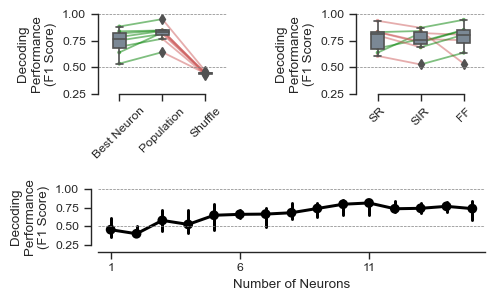

In [51]:
f = plt.figure(figsize=(5, 3))

axes = f.subplot_mosaic([["A", "B"], ["C", "C"]], gridspec_kw=dict(height_ratios=[1, 0.7]))

ax_box = axes["A"]
ax_box.set_ylim(0.25, 1)
ax_box.set_yticks([0.25, 0.5, 0.75, 1])
pg.plot_paired(
    data=pop, 
    dv="value", 
    subject="session_name", 
    within="metric", 
    boxplot_in_front=True,
    pointplot_kwargs=dict(alpha=0.5),
    boxplot_kwargs=dict(width=0.3),
    ax=ax_box,
    )

ax_box.set_xticklabels(ax_box.get_xticklabels(), rotation=45)
ax_box.set_ylabel("Decoding\nPerformance\n(F1 Score)")
# ax_box.set_title("Decoder\nPerformance", pad=20)
ax_box.set_xlabel("")
ax_box.axhline(0.5, color="grey", linewidth=0.5, linestyle="--")
ax_box.axhline(1, color="grey", linewidth=0.5, linestyle="--")
##

ax_box2 = axes["B"]
ax_box2.set_ylim(0.25, 1)
ax_box2.set_yticks([0.25, 0.5, 0.75, 1])
pg.plot_paired(
    data=dropout.dropna(), 
    dv="score", 
    subject="session_name", 
    within="dropped", 
    boxplot_in_front=True,
    pointplot_kwargs=dict(alpha=0.5),
    boxplot_kwargs=dict(width=0.3),
    ax=ax_box2,
    order=["SR", "SIR", "FF"]
    )

ax_box2.set_xticklabels(ax_box2.get_xticklabels(), rotation=45)
ax_box2.set_ylabel("Decoding\nPerformance\n(F1 Score)")
ax_box2.set_xlabel("")
ax_box2.axhline(0.5, color="grey", linewidth=0.5, linestyle="--")
ax_box2.axhline(1, color="grey", linewidth=0.5, linestyle="--")

ax_line = axes["C"]
ax_line.set_ylim(0.25, 1)
ax_line.set_yticks([0.25, 0.5, 0.75, 1])

sns.pointplot(data=limit, x="n_neurons", y="pop_score", ax=ax_line, color="black", estimator=np.median)

ax_line.xaxis.set_major_locator(plt.MultipleLocator(5))
ax_line.set_ylabel("Decoding\nPerformance\n(F1 Score)")
ax_line.set_xlabel("Number of Neurons")
ax_line.axhline(0.5, color="grey", linewidth=0.5, linestyle="--")
ax_line.axhline(1, color="grey", linewidth=0.5, linestyle="--")
f.subplots_adjust(wspace=1, hspace=1.4)
sns.despine(fig=f)
sns.despine(ax=ax_line, offset=5)

f.savefig(fig_dir / "fs_fast - decoding_performance_box_line.png", bbox_inches="tight", dpi=300)


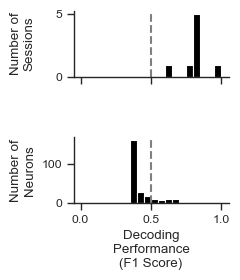

In [52]:
f = plt.figure(figsize=(2, 2.5))

ax_session, ax_neurons = f.subplots(2, 1, sharex=True)

bins = np.arange(0, 1.05, 0.05)

ax_session.hist(
    pop.query("metric == 'Population'")["value"], 
    bins=bins, 
    color="black"
    )
ax_session.axvline(0.5, color="grey", linewidth=1.5, linestyle="--")


ax_neurons.hist(
    unit["F1 Score"], 
    bins=bins, 
    color="black"
    )
ax_neurons.axvline(0.5, color="grey", linewidth=1.5, linestyle="--")
ax_session.set_ylabel("Number of\nSessions")
ax_neurons.set_ylabel("Number of\nNeurons")

ax_neurons.set_xlabel("Decoding\nPerformance\n(F1 Score)")


f.subplots_adjust(hspace=0.9)

sns.despine(fig=f)
f.align_ylabels()

f.savefig(fig_dir / "fs_fast - decoding_hist.png", bbox_inches="tight", dpi=300)


In [11]:
def get_psth_subset(
    t_start, 
    t_stop, 
    block="base_shock", 
    sessions=None, 
    window=(0.05, 0.2)
    ):
    neuron_types = load_derived_generic("neuron_types.csv").dropna()
    sessions = sessions or ExperimentInfo.foot_shock_sessions_all
    spikes = SpikesHandler(
        block=block,
        bin_width=1,
        session_names=sessions,
        t_start=t_start,
        t_stop=t_stop,
    ).spikes.merge(neuron_types)
    events = (
        load_events(block_name=block)
        .query("event_s >=  @t_start and event_s <= @t_stop")
    )
    transformer = ShockUtils()
    df_binned = transformer.aligned_binned_from_spikes(
        spikes, 
        events, 
        sessions=None,
        bin_width=0.01,
        )
    df_psth = (
        transformer.average_trace_from_aligned_binned(
                df_binned
            )
            .reset_index()
            .melt(id_vars="bin", var_name="neuron_id", value_name="counts")
            .assign(zcounts=lambda x: x.groupby("neuron_id")["counts"].transform(lambda x: zmap(x, x[:45])))
            .merge(neuron_types[["neuron_id", "neuron_type", "session_name"]].drop_duplicates())
            .assign(window=lambda x: np.where(
                (x["bin"] < window[0]) | (x["bin"] > window[1]), "pre", "post"
            ))
    )
    return df_psth

In [16]:
df_psth = (
    get_psth_subset(0, 600)
    .pivot_table(index="bin", columns="neuron_id", values="counts")
)

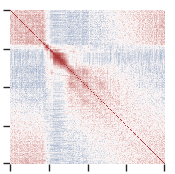

In [21]:
from drn_interactions.plots.heatmaps import similarity_map

def plot_similarity_map(df, **figure_kwargs):
    f = plt.figure(**figure_kwargs)
    ax = f.subplots()
    similarity_map(
        df_binned_piv=df,
        z=True, 
        ax=ax,
        heatmap_kwargs=dict(cmap="vlag", vmin=-0.7, vmax=0.7, robust=False, cbar=False),
        )
    ax.set_yticks([0, 50, 100, 150, 199])
    ax.set_xticks([0, 50, 100, 150, 199])
    return f, ax


f, ax = plot_similarity_map(df_psth.dropna(axis=1), figsize=(2, 2))

f.savefig(fig_dir / "fs_fast_similarity_map.png", bbox_inches="tight", dpi=300)